In [30]:
import pandas as pd
import random

In [43]:
import pandasql as ps

In [64]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
df = pd.read_excel('Online Retail.xlsx')

In [32]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [33]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [34]:
df_na = df.dropna().reset_index(drop=True)

In [35]:
df_na.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [36]:
df_na.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [37]:
df_na['StockCode']= df_na['StockCode'].astype(str)

In [38]:
customers = df_na["CustomerID"].unique().tolist()
len(customers)

4372

In [41]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.1*len(customers)))]

# split data into train and validation set
train_df = df_na[df_na['CustomerID'].isin(customers_train)]
validation_df = df_na[~df_na['CustomerID'].isin(customers_train)]

In [42]:
train_df.shape

(40340, 8)

In [ ]:
q1 = 'select StockCode from df_na where CustomerID==17859.0'
list_products = ps.sqldf(q1,locals()).values
flat_list = [item for sublist in list_products for item in sublist]

In [ ]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes

for i in customers_train:
    q1 = 'select StockCode from df_na where CustomerID=='+str(i)
    list_products = ps.sqldf(q1,locals()).values
    flat_list = [item for sublist in list_products for item in sublist]
    print(flat_list)
    purchases_train.append(flat_list)
        
        
        

In [46]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(373502, 403400)

In [47]:
model.init_sims(replace=True)

In [48]:
print(model)

Word2Vec(vocab=1841, size=100, alpha=0.03)


In [62]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

/home/nitin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(1841, 100)

In [63]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1841 samples in 0.011s...
[t-SNE] Computed neighbors for 1841 samples in 0.992s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1841
[t-SNE] Computed conditional probabilities for sample 1841 / 1841
[t-SNE] Mean sigma: 0.300642
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.055405
[t-SNE] KL divergence after 300 iterations: 1.626074


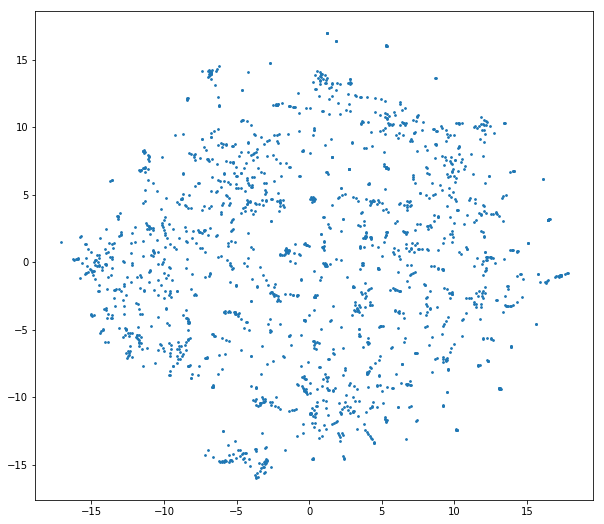

In [66]:

plt.figure(figsize=(10,9))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=3, cmap='Spectral')

In [67]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

/home/nitin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [70]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

In [77]:
similar_products(model['15044D'])

/home/nitin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/home/nitin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('PURPLE PAPER PARASOL', 0.9245828986167908),
 ('PINK PAPER PARASOL ', 0.915785551071167),
 ('ASSORTED TUTTI FRUTTI MIRROR', 0.8740936517715454),
 ('PARTY INVITES BALLOON GIRL', 0.8465176224708557),
 ('CREAM SLICE FLANNEL CHOCOLATE SPOT ', 0.8371771574020386),
 ('CREAM SLICE FLANNEL PINK SPOT ', 0.8310484886169434)]